<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/7_13deepnn%E5%9F%BA%E7%A4%8E%E6%A8%A1%E5%9E%8B%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 基本函式匯入
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # 處理進度條

# pytorch引入
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 資料前處理

In [ ]:
# 確認torch版本
torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# 定義分類個數
NUM_CLASS = 10

cleass_nam=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

class_map = {cls : i for i, cls in enumerate(class_name)}
type(class_map)

dict

In [ ]:
# 下載資料集

train_ds = torchvision.datasets.CIFAR10("data", # 儲存路徑
                     train=True, # 訓練集或資料集 test=true
                     download=True # 是否下載
                     )
val_ds = torchvision.datasets.CIFAR10("data",
                    train=False,
                    download=True
                    )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 確認資料集大小
print(len(train_ds))
print(len(val_ds))
type(train_ds)

50000
10000


torchvision.datasets.cifar.CIFAR10

In [ ]:
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]
# 將圖片資料轉成numpy形式方便運算
img_np = np.array(img)
classname = class_name[label]
print(idx)
print(img_np.shape)
print(label)
print(classname)

13295
(32, 32, 3)
7
horse


In [ ]:
# 資料前處理
preprocess = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Build dataset with data preprocess
train_ds = torchvision.datasets.CIFAR10('data',
    train=True,
    download=True,
    transform=preprocess)
val_ds = torchvision.datasets.CIFAR10('data',
    train=False,
    download=True,
    transform=preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Random select a sample
idx = np.random.randint(low=0, high=len(train_ds))
img, label = train_ds[idx]

# Type of img and label
# 將圖片資料轉成torch tensor形式 讓模型好運算
print(idx)
print(type(img), type(label))
print(img.shape)

1970
<class 'torch.Tensor'> <class 'int'>
torch.Size([3, 32, 32])


In [ ]:
# 使用 DataLoader 來產生各自的batch資料集
# 資料批次化
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader

In [ ]:
# 確認資料的shape 由於適用矩陣運算 因次確認張量很重要
for x, y in train_dataloader:
    print("type ", type(x), type(y))
    # N是批次數量256
    print("Shape of x [N, C, H, W]: ", x.shape, x.dtype)
    print("Shape of y [N]: ", y.shape, y.dtype)
    break

type  <class 'torch.Tensor'> <class 'torch.Tensor'>
Shape of x [N, C, H, W]:  torch.Size([256, 3, 32, 32]) torch.float32
Shape of y [N]:  torch.Size([256]) torch.int64


(<matplotlib.image.AxesImage at 0x7c2e686fec80>, tensor(0))

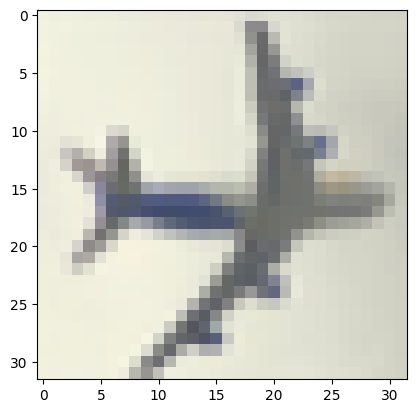

In [ ]:
# permute: [C, H, W] -> [H, W, C]
# 置換通道順序
plt.imshow(x[0].permute(1, 2, 0)), y[0]

In [ ]:
# 建立模型
# 先確定要用甚麼硬體做運算
device = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 32
print(f'using device : {device}')

using device : cpu


In [ ]:
# 建模
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64),
    nn.ReLU(),
    nn.Linear(64,128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128,NUM_CLASS),
    )

In [ ]:
# 第二種模組化的建模方式
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.base_model = nn.Sequential(
            nn.Linear(in_features=IMG_SIZE*IMG_SIZE*3, out_features=64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,NUM_CLASS),
        )
    # 執行模型 餵進資料 x 進到模型
    def forward(self, x):
      x = self.flatten(x)
      logits = self.base_model(x)
      return logits

In [ ]:
model = NeuralNet().to(device)

### 3種看模型的方法

In [ ]:
print(model)

NeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (base_model): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
import torchsummary
torchsummary.summary(model, input_size=(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 64]         196,672
              ReLU-3                   [-1, 64]               0
            Linear-4                  [-1, 128]           8,320
              ReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.85
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


In [ ]:
# Use torchinfo to print advanced info
!pip install torchinfo

import torchinfo
torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [256, 10]                 --
├─Flatten: 1-1                           [256, 3072]               --
├─Sequential: 1-2                        [256, 10]                 --
│    └─Linear: 2-1                       [256, 64]                 196,672
│    └─ReLU: 2-2                         [256, 64]                 --
│    └─Linear: 2-3                       [256, 128]                8,320
│    └─ReLU: 2-4                         [256, 128]                --
│    └─Linear: 2-5                       [256, 128]                16,512
│    └─ReLU: 2-6                         [256, 128]                --
│    └─Linear: 2-7                       [256, 10]                 1,290
Total params: 222,794
Trainable params: 222,794
Non-trainable params: 0
Total mult-adds (M): 57.04
Input size (MB): 3.15
Forward/backward pass size (MB): 0.68
Params size (MB): 0.89
Estimated Total Size (MB): 4

### 建完模型後開始訓練

In [ ]:
# 先確定損失函數為何?
loss_fn = nn.CrossEntropyLoss()
# 確定優化器
optimizer = torch.optim.SGD(params = model.parameters(), # 總參數
               lr=1e-2 #學習率
                            )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    # 把模型轉成訓練模式
    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0

    # 把資料一批一批的從dataloader裡面取出來
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        # 把資料也丟到cpu上面
        x, y = x.to(device), y.to(device) # move data to device

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        # 讓optimizer幫忙更新
        optimizer.step() # update model params

        # 紀錄logs 可以自己客製化 其他上面的皆為固定
        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    # 轉換模型模式
    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # 不做梯度下降計算 因此也不用更新
    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
EPOCHS = 10
logs = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# tqdm是進度條
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_dataloader, model, loss_fn)

    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 2.2968, train_acc: 0.140     val_loss: 2.2916, val_acc: 0.139 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 1     train_loss: 2.2815, train_acc: 0.142     val_loss: 2.2674, val_acc: 0.159 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 2     train_loss: 2.2421, train_acc: 0.188     val_loss: 2.2068, val_acc: 0.207 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 3     train_loss: 2.1541, train_acc: 0.225     val_loss: 2.1036, val_acc: 0.226 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 4     train_loss: 2.0672, train_acc: 0.245     val_loss: 2.0409, val_acc: 0.249 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 5     train_loss: 2.0174, train_acc: 0.264     val_loss: 1.9991, val_acc: 0.276 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 6     train_loss: 1.9794, train_acc: 0.280     val_loss: 1.9632, val_acc: 0.289 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 7     train_loss: 1.9456, train_acc: 0.294     val_loss: 1.9285, val_acc: 0.304 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 8     train_loss: 1.9159, train_acc: 0.307     val_loss: 1.9033, val_acc: 0.314 


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 9     train_loss: 1.8941, train_acc: 0.316     val_loss: 1.9148, val_acc: 0.312 


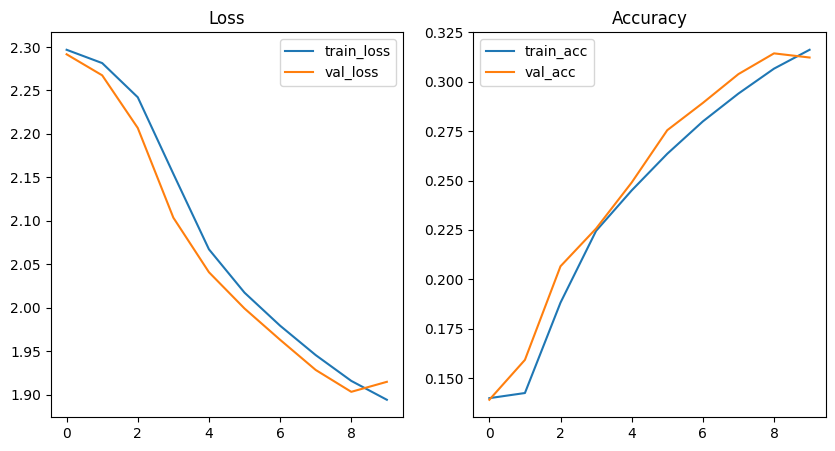

In [ ]:
# Plot loss curve
# 畫圖
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

In [ ]:
# model parameters
model.state_dict()

OrderedDict([('base_model.0.weight',
              tensor([[-0.0116, -0.0038, -0.0208,  ..., -0.0140, -0.0255,  0.0013],
                      [-0.0123, -0.0160,  0.0142,  ..., -0.0123,  0.0029,  0.0065],
                      [ 0.0142, -0.0039,  0.0018,  ...,  0.0024,  0.0050,  0.0078],
                      ...,
                      [-0.0140,  0.0032, -0.0049,  ..., -0.0212, -0.0026, -0.0214],
                      [ 0.0163,  0.0101, -0.0117,  ...,  0.0042,  0.0103,  0.0147],
                      [-0.0081,  0.0104, -0.0091,  ..., -0.0183, -0.0186, -0.0138]])),
             ('base_model.0.bias',
              tensor([ 1.1571e-02, -3.8800e-04, -1.6923e-02,  1.6116e-02, -7.7388e-03,
                      -5.6550e-02,  8.8322e-04, -5.9746e-05,  9.6205e-03,  2.5783e-02,
                      -8.7707e-03, -2.9286e-03,  2.3056e-02,  7.1658e-03,  1.7202e-02,
                      -1.1327e-02,  2.0208e-02, -9.4084e-03, -1.5181e-02,  6.6722e-04,
                      -1.2290e-02, -1.9327e-02

儲存參數

In [ ]:
PATH = './model_weights.pth' # .pth or .pt
# save weights
# 用字典的形式存
torch.save(model.state_dict(), PATH)

# load weights
# 儲存成功會顯示 : <All keys matched successfully>
model.load_state_dict(torch.load(PATH))

儲存模型

In [ ]:
MODEL_PATH = './model.pth'
# save model
torch.save(model, MODEL_PATH)
# load model
model = torch.load(MODEL_PATH)

In [ ]:
# load model
model = NeuralNet()

model.load_state_dict(torch.load(PATH))
model.eval()

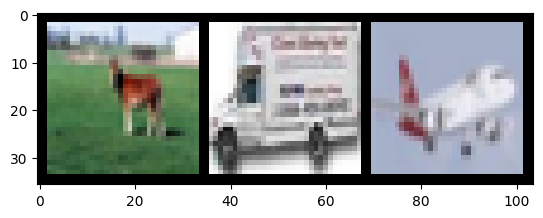

In [ ]:
# take first 2 images
# 取出兩張圖片來進行測試
n = 3
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    # make_grid() 將多個圖片結合再一起 默認padding(間格)是2
    images_grid = torchvision.utils.make_grid(images[:n], padding=2)
    images_grid = images_grid.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    plt.imshow(images_grid.numpy())
    break

### 這邊出來的raw_prediction的數值是還沒有經過soft_max()轉換的值

In [ ]:
# take first 2 images
n = 2
for (images, labels) in val_dataloader:
    images, labels = images[:n], labels[:n]
    break

# Predict by model
with torch.no_grad():
    pred = model(images) # predict logits
print('raw_prediction logtis', pred, pred.shape, sep="\n")

raw_prediction logtis
tensor([[ 2.5468e+00,  6.8997e-01, -3.7089e-01, -8.5021e-01, -1.7698e+00,
         -1.0795e+00, -3.4006e+00, -1.5731e+00,  3.3036e+00,  5.4347e-01],
        [-4.0634e-01, -2.3848e-01,  1.4185e-01,  1.8290e-01, -3.3045e-03,
         -2.4190e-01, -1.2219e-01,  6.1746e-01, -9.7164e-01,  5.1934e-02]])
torch.Size([2, 10])


In [ ]:
# dim=1 沿著每一列的方向進行softmax轉換
pred_softmax = nn.Softmax(dim=1)(pred) # probabilities
print('prediction after softmax', pred_softmax, pred_softmax.shape, sep="\n")

prediction after softmax
tensor([[0.2802, 0.0438, 0.0151, 0.0094, 0.0037, 0.0075, 0.0007, 0.0046, 0.5973,
         0.0378],
        [0.0682, 0.0807, 0.1181, 0.1230, 0.1021, 0.0804, 0.0907, 0.1900, 0.0388,
         0.1079]])
torch.Size([2, 10])


In [ ]:
# max_prob: max probability of each samples
# predicted_cls: the index of max prob
max_prob, predicted_cls = torch.max(pred_softmax, dim=1)
print("預測出來的最大機率: ",max_prob)
print("預測出來的類別: ",predicted_cls)

預測出來的最大機率:  tensor([0.5973, 0.1900])
預測出來的類別:  tensor([8, 7])


In [ ]:
predicted_cls = pred_softmax.argmax(dim=1)
predicted_cls

tensor([8, 7])

In [ ]:
pred_softmax.argmax(dim=1)

tensor([8, 7])

In [ ]:
print('GroundTruth: ', ' '.join(cleass_nam[labels[j]] for j in range(n)))
print('Prediction: ', ' '.join(cleass_nam[predicted_cls[j]] for j in range(n)))

GroundTruth:  ship horse
Prediction:  ship horse


#### Generate file for Kaggle

https://www.kaggle.com/competitions/mnist-sai

In [ ]:
class MNISTTestDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.x_data = data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.transforms.Normalize((0.5,), (0.5,))
        ])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        img = self.x_data[idx]
        img = self.transform(img)
        return img

test_ds = MNISTTestDataset(x_test)
test_loader = torch.utils.data.DataLoader(test_ds, BATCH_SIZE)

In [ ]:
# Predict all data
y_pred = []

model.to(device)
model.eval()

with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        pred = model(x)
        y_pred.append(pred)

y_pred = torch.cat(y_pred).argmax(1).cpu().numpy()
y_pred.shape

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['Id'] = [str(i) for i in range(len(x_test))]
df['Category'] = y_pred
df.to_csv('result.csv', index=None)
df

In [ ]:
import matplotlib.pyplot as plt
y=torch.tensor(x_test)
y_grid = torchvision.utils.make_grid(y[:4])
y_grid = y_grid.permute(1,2,0)
plt.imshow(y_grid)